In [1]:
import metaSI
import numpy as np
from matplotlib import pyplot as plt
import torch

## Data generation

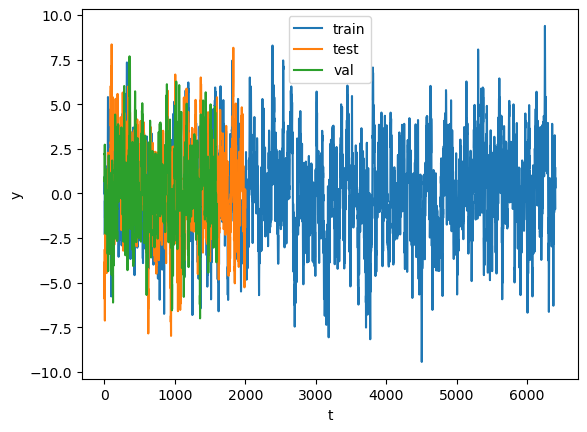

In [2]:
def get_data(ulist,elist=None,x0=0):
    x = x0
    ylist = []
    if elist is None:
        elist = np.random.uniform(-1,1,size=len(ulist))
    for u,e in zip(ulist,elist):
        ylist.append(x)
        x = (0.9+e*0.2)*x + u
    return ylist

Nsamples = 10_000
np.random.seed(20)
ulist = np.random.normal(size=Nsamples)
ylist = get_data(ulist)


data = metaSI.System_data(u=ulist, y=ylist)
train, test = data.train_test_split(0.2)
train, val = train.train_test_split(0.2)
train.plot(show=False)
test.plot(show=False)
val.plot(show=False)
plt.legend(['train','test','val'])
plt.show()


In [3]:

Nsamples = 500
Ntransient = 200
Nensemble = 5000

np.random.seed(30)
ulist_ensemble = np.random.normal(size=Ntransient+Nsamples)
ylists_ensemble = []
for ensemble_i in range(Nensemble):
    ylists_ensemble.append(get_data(ulist_ensemble)[Ntransient:])
ulist_ensemble = ulist_ensemble[Ntransient:]
ylists_ensemble = np.array(ylists_ensemble).T #(time, batch) or (batch,time)?

test_ensemble = metaSI.System_data(ulist_ensemble, ylists_ensemble)
test_ensemble_0 = metaSI.System_data(ulist_ensemble, ylists_ensemble[:,0])


In [4]:
test_ensemble, test_ensemble_0

(System_data of length: 500 nu=None ny=5000 normed=False dt=None,
 System_data of length: 500 nu=None ny=None normed=False dt=None)

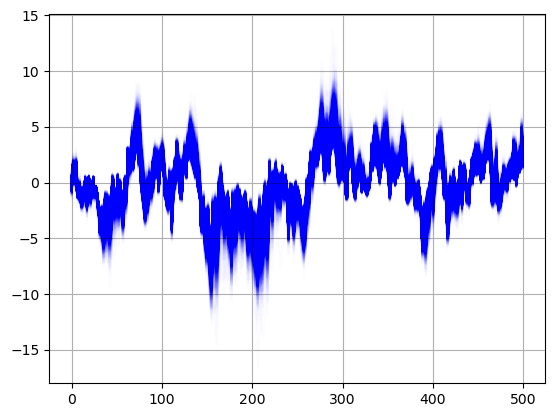

In [5]:
plt.plot(ylists_ensemble,'b',alpha=0.01)
plt.grid()
plt.show()

## Meta-state-space Model creation

In [6]:
load = True
if not load:
    nu = None
    ny = None
    norm = metaSI.data.Norm(u=train.u, y=train.y)
    print(norm)
    sys = metaSI.meta_models.Meta_SS_model(nu=nu, ny=ny, norm=norm, nz=3)
    sys.fit(train, val, loss_kwargs=dict(nf=50, burn_time=20, parameter_init=False))
    sys.save_to_file('./models/meta_ss_model_parametric_noise_example')
else:
    sys = torch.load('./models/meta_ss_model_parametric_noise_example')


In [7]:
test_sim = sys.multi_step(test[200:300], nf='sim')

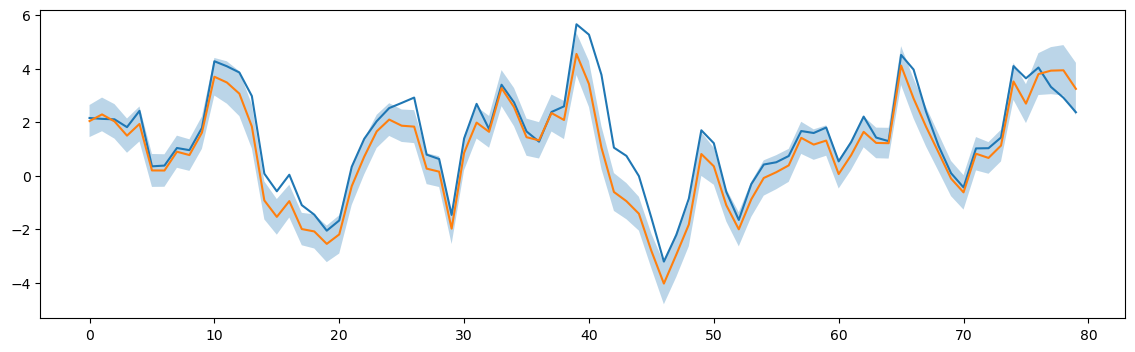

In [8]:
plt.figure(figsize=(14,4))
plt.plot(test_sim.yfuture[0][20:].numpy())
mean = test_sim.y_dists[0][20:].mean.numpy()
std = test_sim.y_dists[0][20:].stddev.numpy()
plt.plot(mean)
plt.fill_between(np.arange(len(mean)), mean-std, mean+std,alpha=0.3)
plt.show()
plt.show()

In [9]:
test_multi_step = sys.multi_step(test[400:], nf=100)

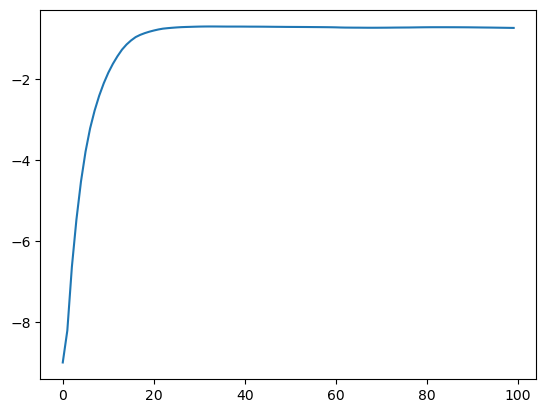

In [10]:
plt.plot(test_multi_step.normalized_log_prob(batch_average=True, time_average=False))
plt.show()

In [11]:
ensemble_sim = sys.multi_step(test_ensemble, nf='sim')


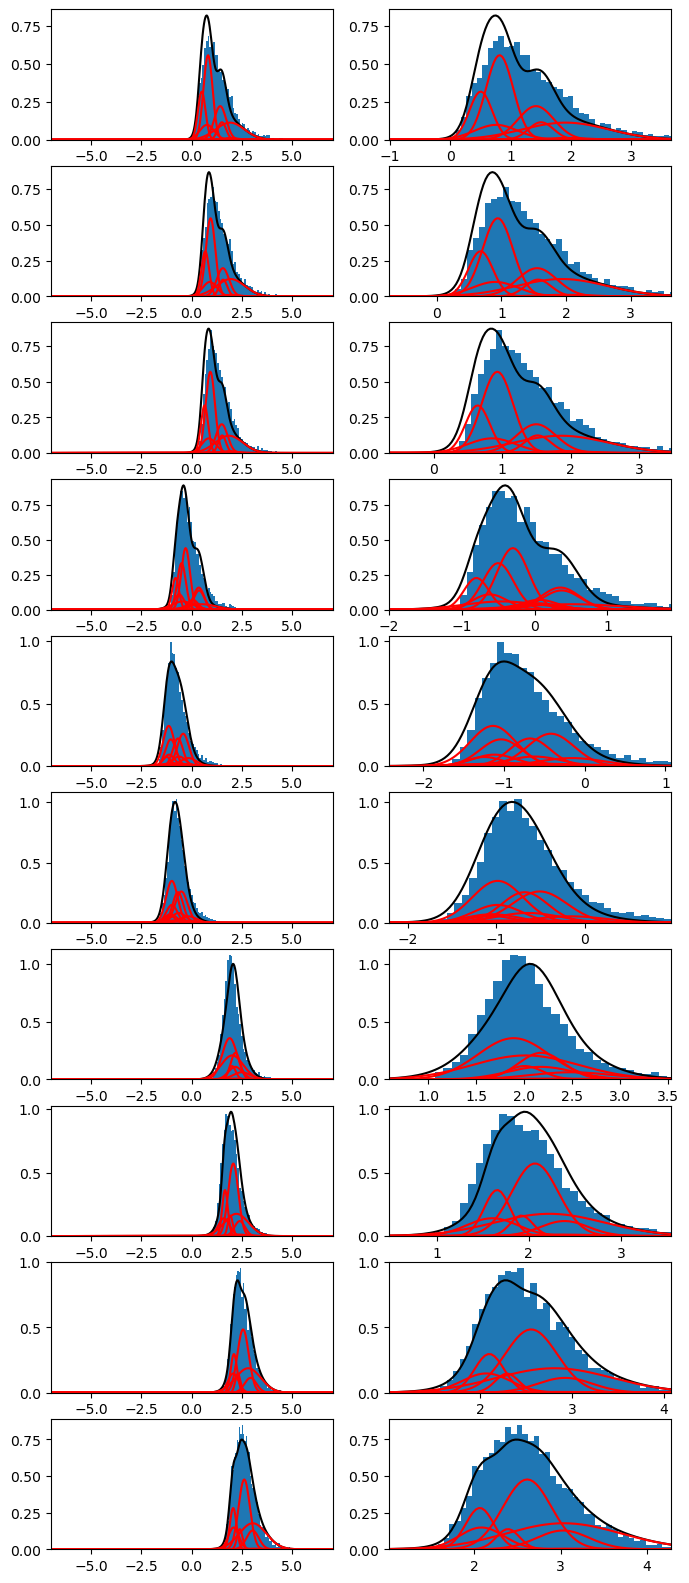

In [12]:
t = 300

ntimes = 10
ytest = torch.linspace(-7,7,400)

plt.figure(figsize=(8,2*ntimes))
for i,t in enumerate(range(300, 300+ntimes)):
    ysampled, ydist = ensemble_sim.yfuture[0,t], ensemble_sim.y_dists[0,t]
    for j in range(2):
        plt.subplot(ntimes,2,1+i*2+j)
        plt.hist(ysampled.numpy(), bins=int(len(ysampled)**0.5),density=True)
        plt.plot(ytest.numpy(),ydist.prob(ytest).numpy(),'k')
        plt.plot(ytest.numpy(),ydist.prob_per_weighted(ytest).numpy(),'r')
        if j==0:
            plt.xlim(torch.min(ytest), torch.max(ytest))
        else:
            plt.xlim(ysampled.mean()-3*ysampled.std(), ysampled.mean()+3*ysampled.std())
plt.show()
